In [29]:
import itertools

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp


In [30]:
# define VRP

customer_count = 30
vehicle_capacity = 3


# the number of vehicle
vehicle_count = 15  ##not a constraint , determinist


##create dataframe 
df = pd.DataFrame({
    'x': np.random.randint(0, 100, customer_count),
    'y': np.random.randint(0, 100, customer_count),
    'demand': np.random.randint(1, 2, customer_count),
})

df.iloc[0]['x'] = 0
df.iloc[0]['y'] = 0
df.iloc[0]['demand'] = 0
df.iloc[-1]['x'] = 50
df.iloc[-1]['y'] = 50
df.iloc[-1]['demand'] = 0

df


,x,y,demand
0,0,0,0
1,2,23,1
2,1,20,1
3,46,98,1
4,36,5,1
5,76,68,1
6,1,34,1
7,10,47,1
8,37,61,1
9,9,35,1


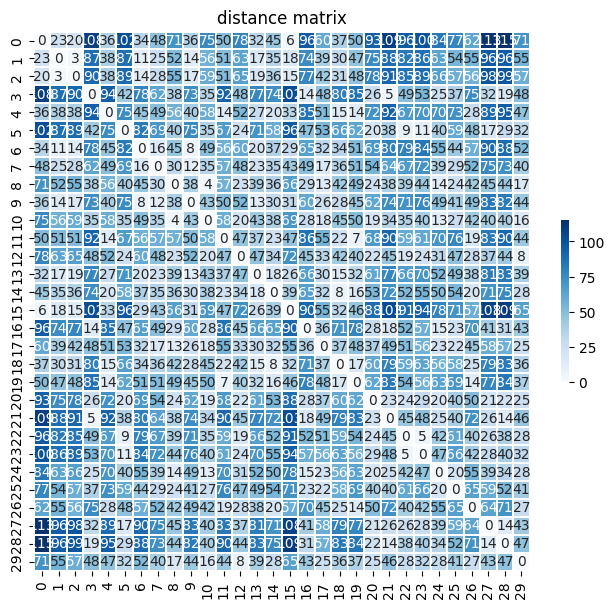

In [31]:
# get distance matrix

distances = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()

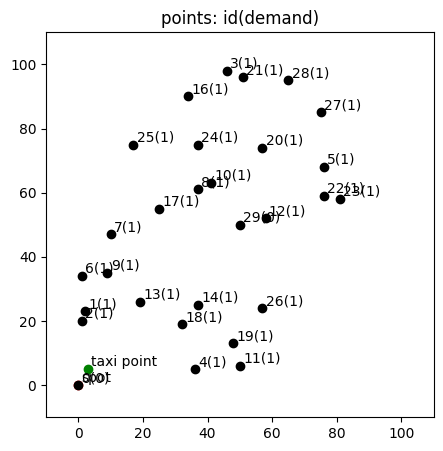

In [32]:
# check VRP state

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'spot')
    if i == 15:
        plt.scatter(row['x'], row['y'], c='green')
        plt.text(row['x'] + 1, row['y'] + 1, 'taxi point')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        demand = row['demand']
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}({demand})')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id(demand)')
plt.show()

In [33]:
# solve with pulp

demands = df['demand'].values

for vehicle_count in range(1,vehicle_count+1):

    # definition of LpProblem instance
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # definition of variables which are 0/1
    ##already includes constaraint sum(Xii) = 0
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]
    u = pulp.LpVariable.dicts('u', (i for i in range(1, customer_count)), lowBound=0, cat='Continuous')

    # add objective function
    problem += pulp.lpSum(distances[i][j] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count)
                          for j in range(customer_count)
                          for i in range (customer_count))

    #constraints

# pickup all points with exact;y one cab
    for j in range(1,customer_count-1):
        problem += pulp.lpSum(x[i][j][k] for i in range(customer_count) for k in range(vehicle_count)) == 1


    #depart from 0
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 0

    #arrive at 15
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[i][customer_count-1][k] for i in range(customer_count-1)) == 1
        problem += pulp.lpSum(x[customer_count-1][j][k] for j in range(customer_count-1)) == 0



    for k in range(vehicle_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0
                              for i in range(customer_count) for j in range(customer_count)) <= vehicle_capacity



#if arrive then leave
    for k in range(vehicle_count):
        for j in range(1,customer_count-1):
            problem += pulp.lpSum( pulp.lpSum(x[i][j][k] for i in range(0,customer_count-1)) ) == ( pulp.lpSum(x[j][m][k] for m in range(1,customer_count)) )





# xij and xji not both 1
    for k in range(vehicle_count):
      for j in range(1,customer_count-1):
          for i in range(1,customer_count-1):
              if (x[i][j][k] if i != j else 0  ==1 ):
                  problem += x[j][i][k] ==0


# # xii not 1
#     for k in range(vehicle_count):
#       for j in range(1,customer_count-1):
#           for i in range(1,customer_count-1):
#               if (x[i][j][k] if i == j else 0 ==1 ):
#                   problem += x[i][j][k] ==0





    #fomula (6) demand constrain
    # tours = []
    # for length in range(2,customer_count):
    #      tours += itertools.combinations(range(1,customer_count), length) ##exclude 0 and lasty point

    # for st in tours: ##st a given path
    #     demand = np.sum([demands[s] for s in st]) ## s = node , sum of demands on a path
    #     arcs = [x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(st, 2) for k in range(vehicle_count)] ## 2 => pair (i,j) xij ==1 if i, j selected
    #     problem += pulp.lpSum(arcs) <= demand -  np.ceil(demand/vehicle_capacity)

    #elimnate subtours
    # Subtour Elimination (MTZ constraints)
    for i in range(1, customer_count):
        problem += u[i] >= 1  # Ensures that each node (except the depot) is visited at least once
        problem += u[i] <= customer_count - 1  # Sets an upper bound for u[i]
    for k in range(vehicle_count):
        for i in range(1, customer_count):
            for j in range(1, customer_count):
                if i != j:
                    problem += u[i] - u[j] + (customer_count - 1) * x[i][j] <= customer_count- 2

   # solve problem
    status = problem.solve()
    print(status)


    if status == 1:
        print('Vehicle Requirements:', vehicle_count)
        print('Moving Distance:', pulp.value(problem.objective))
        break

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/prachit/.local/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/1decec62676c4182a5ea8e9cc1c4dd7a-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/1decec62676c4182a5ea8e9cc1c4dd7a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 936 COLUMNS
At line 9407 RHS
At line 10339 BOUNDS
At line 11210 ENDATA
Problem MODEL has 931 rows, 899 columns and 5860 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.01

-1
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/prachit/.local/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/794ca40c0c1c48cf83d726c2d1dac017-pulp.mps -timeMod

/tmp/ipykernel_18113/1757053199.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Dark2')


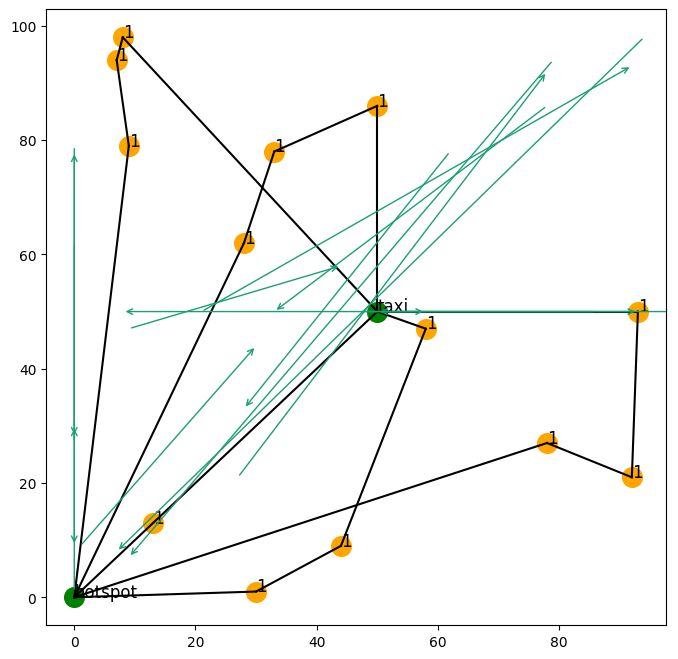

Cbc0010I After 1075000 nodes, 7996 on tree, 732.98969 best solution, best possible 722.2076 (1659.28 seconds)
Cbc0010I After 1076000 nodes, 7890 on tree, 732.98969 best solution, best possible 722.42418 (1660.43 seconds)
Cbc0010I After 1077000 nodes, 7790 on tree, 732.98969 best solution, best possible 722.65933 (1661.65 seconds)
Cbc0010I After 1078000 nodes, 7506 on tree, 732.98969 best solution, best possible 722.65933 (1662.92 seconds)
Cbc0010I After 1079000 nodes, 7379 on tree, 732.98969 best solution, best possible 722.91146 (1664.32 seconds)
Cbc0010I After 1080000 nodes, 7260 on tree, 732.98969 best solution, best possible 723.15836 (1665.56 seconds)
Cbc0010I After 1081000 nodes, 7135 on tree, 732.98969 best solution, best possible 723.39975 (1667.31 seconds)
Cbc0010I After 1082000 nodes, 6942 on tree, 732.98969 best solution, best possible 723.39975 (1668.31 seconds)
Cbc0010I After 1083000 nodes, 6773 on tree, 732.98969 best solution, best possible 723.6798 (1669.57 seconds)
Cbc

In [ ]:
# visualization : plotting with matplolib
plt.figure(figsize=(8,8))
for i in range(customer_count):    
    if i == 0:
        plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='green', s=200)
        plt.text(df.iloc[i]['x'], df.iloc[i]['y'], "hotspot", fontsize=12)
    elif i == customer_count -1:
        plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='green', s=200)
        plt.text(df.iloc[i]['x'], df.iloc[i]['y'], "taxi", fontsize=12)
    else:
        plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='orange', s=200)
        plt.text(df.iloc[i]['x'], df.iloc[i]['y'], str(df.demand[i]), fontsize=12)

cmap = matplotlib.cm.get_cmap('Dark2')
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor=cmap(v))

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                #plt.annotate('', xy=[df.iloc[i]['x'], df.iloc[j]['x']], xytext=[df.iloc[i]['y'], df.iloc[j]['y']], arrowprops=arrowprops)
                plt.plot([df.iloc[i]['x'], df.iloc[j]['x']], [df.iloc[i]['y'], df.iloc[j]['y']], c="black")

plt.show() 